# Moving window operations

Process large rasters efficiently using spatial decomposition. JAXScape's `WindowOperation` divides landscapes into overlapping windows with buffer zones, enabling memory-efficient sequential processing or GPU-accelerated batch operations.

### Prerequisites
```bash
pip install jaxscape rasterio matplotlib
```

In [18]:
import rioxarray
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jaxscape import WindowOperation, padding

Load habitat quality raster for demonstration.

In [19]:
# Load habitat quality raster
raster = rioxarray.open_rasterio("../data/suitability.tif", masked=True)
quality = jnp.array(
    raster.sel(band=1).fillna(0),
    dtype="float32"
)  # Replace no-data values with 0

print(f"Raster shape: {quality.shape}")
print(f"Value range: [{quality.min():.2f}, {quality.max():.2f}]")

Raster shape: (107, 182)
Value range: [0.00, 100.00]


/Users/victorboussange/projects/jaxscape/.venv/lib/python3.12/site-packages/pyproj/crs/_cf1x8.py:515: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


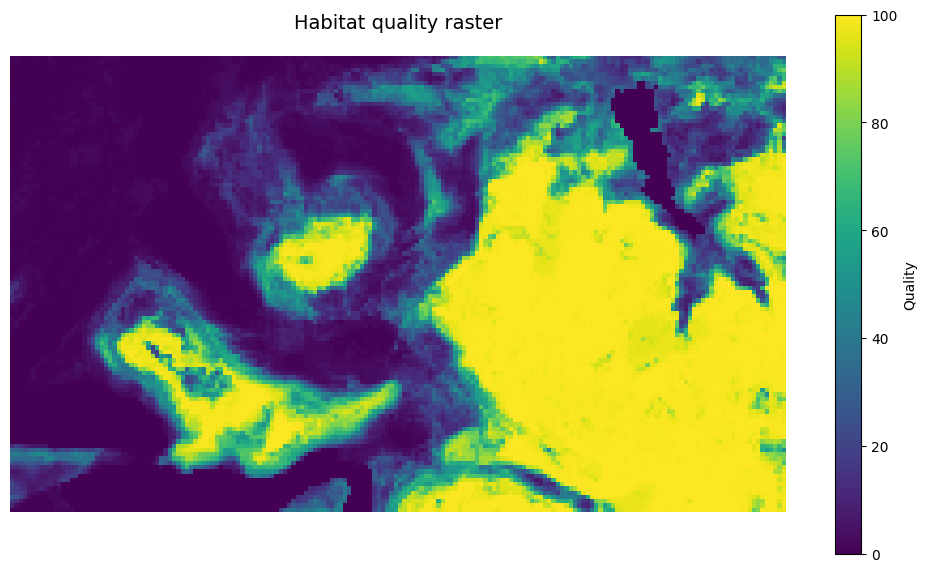

In [20]:
# Visualize the full raster
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(quality, cmap='viridis')
ax.set_title('Habitat quality raster', fontsize=14, pad=20)
ax.axis('off')
plt.colorbar(im, ax=ax, label='Quality', shrink=0.7)
plt.tight_layout()
plt.show()

## Initialize window operation

Window parameters define the tile size and overlap. Before feeding the raster to the `WindowOperation` class, we can use `jaxscape.padding` to ensure that windows have complete neighborhoods; `WindowOperation` will error otherwise.

In [21]:
buffer_size = 10  # Overlap zone to handle edge effects
window_size = 50  # Core area of each window (in pixels)

quality_padded = padding(quality, buffer_size, window_size)

print(f"\nOriginal raster shape: {quality.shape}")
print(f"Padded raster shape: {quality_padded.shape}")

# Initialize window operation manager
window_op = WindowOperation(
    shape=quality_padded.shape,
    window_size=window_size,
    buffer_size=buffer_size
)

print(f"Total number of windows: {window_op.nb_steps}")



Original raster shape: (107, 182)
Padded raster shape: (120, 220)
Total number of windows: 8


## Lazy iterator: memory-efficient processing

The lazy iterator yields windows one at a time (via Python generator), ideal for memory-constrained environments or sequential processing. Each iteration provides window coordinates `(x, y)` and the data array. This enables processing arbitrarily large rasters as long as individual windows fit in memory.

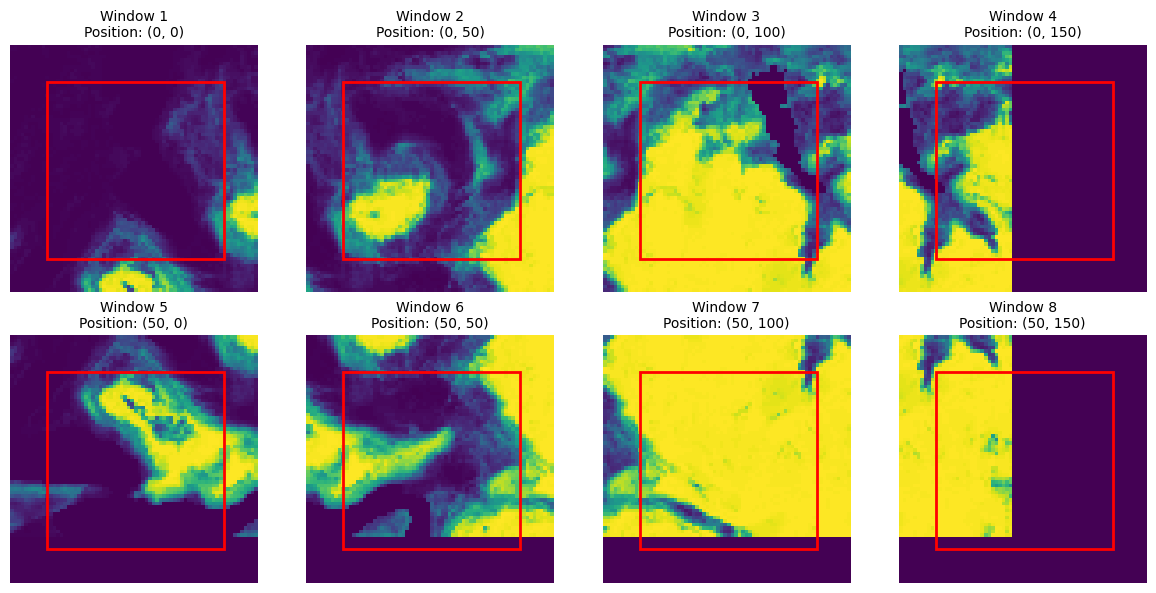

Processed 8 windows (red rectangles = core areas)


In [22]:
# Visualize all windows using lazy iteration
n_windows = window_op.nb_steps
n_cols = 4
n_rows = int(jnp.ceil(n_windows / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))
axs = axs.flatten() if n_windows > 1 else [axs]

for i, (xy, window) in enumerate(window_op.lazy_iterator(quality_padded)):
    ax = axs[i]
    im = ax.imshow(window, cmap='viridis')
    ax.set_title(f'Window {i+1}\nPosition: ({xy[0]}, {xy[1]})', fontsize=10)
    ax.axis('off')
    
    # Draw rectangle showing core area (excluding buffer)
    from matplotlib.patches import Rectangle
    rect = Rectangle(
        (buffer_size, buffer_size),
        window_size, window_size,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)

# Hide unused subplots
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

print(f"Processed {i+1} windows (red rectangles = core areas)")

## Eager iterator: vectorized batch processing

The eager iterator loads all windows into memory at once, returning coordinate and data arrays with shapes `(n_windows, 2)` and `(n_windows, height, width)`. This enables vectorized operations across all windows simultaneously via `jax.vmap`, dramatically accelerating GPU/TPU processing. The trade-off is higher memory consumption.

In [23]:
# Load all windows at once for batch processing
xy_coords, windows = window_op.eager_iterator(quality_padded)

print(f"Coordinates shape: {xy_coords.shape}")
print(f"Windows shape: {windows.shape}")

Coordinates shape: (8, 2)
Windows shape: (8, 70, 70)


## Update raster with processed windows

The `update_raster_with_focal_window` method replaces a window's core area (excluding buffers) with new data. It automatically handles buffer zones by writing only core regions, maintaining spatial continuity across window boundaries.

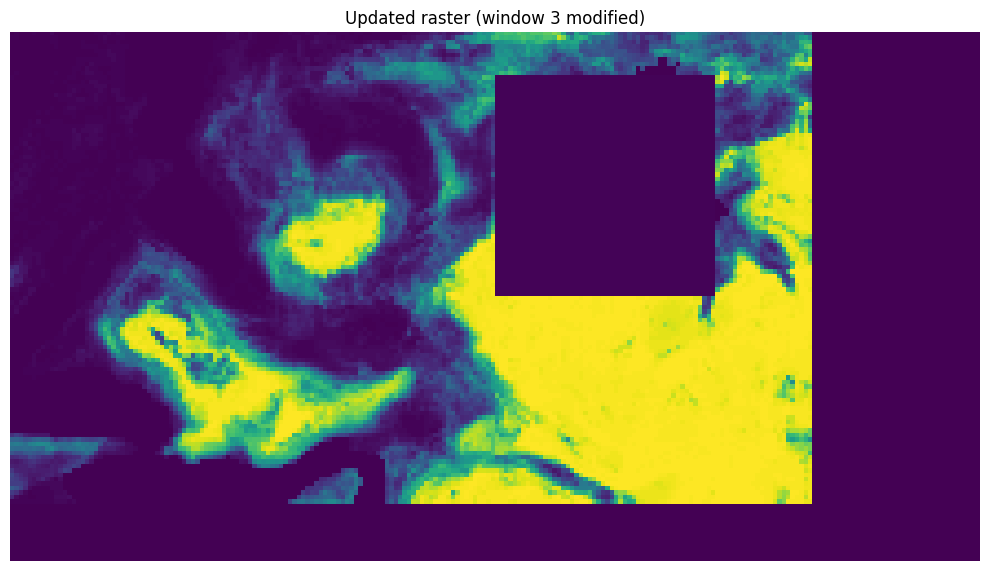

In [24]:
# Example: Replace window 3's core area with ones (demonstrating update)
window_index = 2  # Zero-indexed: window 3
new_window = jnp.ones(windows[window_index].shape, dtype="float32")

# Update the padded raster
updated_raster = window_op.update_raster_with_core_window(
    xy_coords[window_index], 
    quality_padded, 
    new_window
)

# Visualize the updated raster
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(updated_raster, cmap='viridis')
ax.set_title(f'Updated raster (window {window_index + 1} modified)', fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.show()
